In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
#from sklearn.metrics import r2_score
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.animation as animation # animation
import imageio 

import fiona
import rasterio
import rasterio.transform
import rasterio.mask
from fiona import Feature, Geometry
from shapely.geometry import mapping, shape
import os

In [20]:
common_years = np.arange(2005,2017)

In [21]:
#Get information from the shapefile

import fiona
from shapely.geometry import shape

shape_file = '/Users/francesco/Desktop/squares.shp.gpkg'

ids = []
boundaries = []

# Open and extract boundaries
with fiona.open(shape_file, "r") as shapefile:
    for feature in shapefile:
        ids.append(int(feature['id'])) #id is registered as a string in the geometry file
        polygon = shape(feature['geometry'])
        bounds = polygon.bounds
        boundaries.append(bounds)

# Create a DataFrame with the information retrieved from the previous block
df = pd.DataFrame({'boundaries': boundaries}, index=ids)

# Sort the dataset according to the index
df = df.sort_index()
pd.set_option('display.max_rows', None)

# Display the DataFrame
print(df)


                                          boundaries
1  (-1992484.4850636236, -693975.9218715788, -148...


In [22]:
df['boundaries'].loc[1]

(-1992484.4850636236,
 -693975.9218715788,
 -1480484.4850636234,
 -181975.9218715788)

Now we extract masks for ice, land grounded and sea

In [24]:
root = '/Users/francesco/Desktop/JPL/JPL_iceshelves_geometryJPL_antarctic_coastline_'
end = '_filled.tif'


ice_mask = pd.DataFrame(index = ids, columns = common_years)
land_mask = pd.DataFrame(index = ids, columns = common_years)
sea_mask = pd.DataFrame(index = ids, columns = common_years)
grounded_ice_mask = pd.DataFrame(index = ids, columns = common_years)

for id in df.index:
    for year in common_years:
        tif_path = root + str(year) + end
        with rasterio.open(tif_path, crs = 'EPSG:3031') as src:

            xmin, ymin, xmax, ymax = df['boundaries'].loc[id]
            window = rasterio.windows.from_bounds(xmin, ymin, xmax, ymax, src.transform)
            image = src.read(1, window=window)

            ice_mask_tmp = np.zeros_like(image, dtype=bool)
            land_mask_tmp = np.zeros_like(image, dtype=bool)
            sea_mask_tmp = np.zeros_like(image, dtype=bool)
            grounded_ice_mask_tmp = np.zeros_like(image, dtype=bool)

            ice_mask_tmp[image == 3] = True
            land_mask_tmp[image == 2] = True
            sea_mask_tmp[image == 0] = True
            grounded_ice_mask_tmp[image == 1] = True

            ice_mask.loc[id, year] = ice_mask_tmp
            land_mask.loc[id, year] = land_mask_tmp
            sea_mask.loc[id, year] = sea_mask_tmp
            grounded_ice_mask.loc[id, year] = grounded_ice_mask_tmp

#save the masks as numpy arrays
cnn_dataset_directory = '/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/'
np.save(cnn_dataset_directory + 'ice_mask.npy', ice_mask)
np.save(cnn_dataset_directory + 'land_mask.npy', land_mask)
np.save(cnn_dataset_directory + 'sea_mask.npy', sea_mask)
np.save(cnn_dataset_directory + 'grounded_ice_mask.npy', grounded_ice_mask)


In [25]:
#creating a boarder mask

from scipy.ndimage import binary_dilation

#now we create the boarders, by expanding the sea ice mask by 1 pixel
boarders = pd.DataFrame(index = ids, columns = common_years)

sea_mask_expanded = sea_mask.copy()

for id in df.index:
    for year in common_years:
        sea_mask_expanded.loc[id, year] = binary_dilation(sea_mask.loc[id, year], iterations=1)
        boarders.loc[id, year] = sea_mask_expanded.loc[id, year]*1 - sea_mask.loc[id, year]*1

        #change boarders to boolean
        boarders.loc[id, year] = boarders.loc[id, year].astype(bool)

#save the boarders as numpy arrays
np.save(cnn_dataset_directory + 'boarders.npy', boarders)


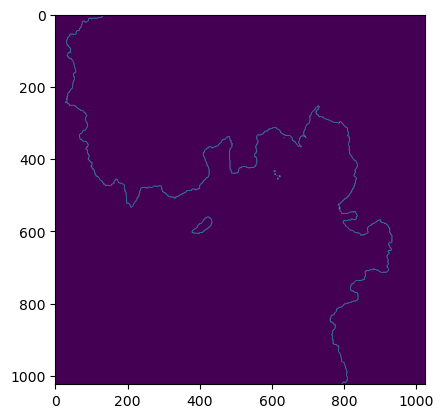

In [26]:
#plot the first mask

#load the boarders
boarders = np.load(cnn_dataset_directory + 'boarders.npy', allow_pickle=True)
boarders = pd.DataFrame(boarders, index = ids, columns = common_years)

plt.imshow(boarders.loc[1, 2015])


Now the thickness from the Paolo dataset

In [257]:
#need to create the list of tif files

tif_files = '/Users/francesco/Desktop/Thesis/Thickness/Thickness_dataset/thickness_2015_warp_ps.tif'

thickness_paolo = pd.DataFrame(index = ids, columns = common_years)
percentile_value = 30

for year in common_years:
    for id in df.index:
        with rasterio.open(tif_files, crs = 'EPSG:3031') as src:

            xmin, ymin, xmax, ymax = df['boundaries'].loc[id]
            window = rasterio.windows.from_bounds(xmin, ymin, xmax, ymax, src.transform)
            image = src.read(1, window=window)

            thickness_paolo_tmp = np.zeros_like(image, dtype=float)
            thickness_paolo_tmp = image

            #calculate the percentile
            percentile = np.percentile(thickness_paolo_tmp[~np.isnan(thickness_paolo_tmp)], percentile_value)

            #add the percentile on the boarders
            thickness_paolo_tmp[boarders.loc[id, year]] = percentile

            #Where there is sea we set the thickness to 0
            thickness_paolo_tmp[sea_mask.loc[id, year]] = 0

            thickness_paolo.loc[id, year] = thickness_paolo_tmp


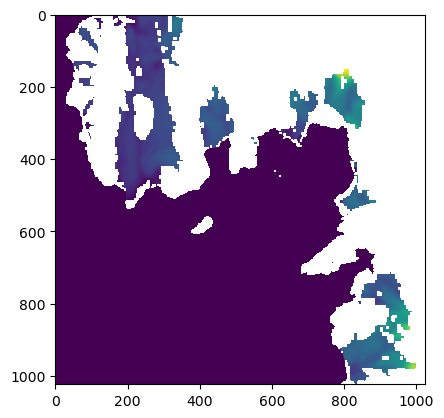

In [258]:
#It worked! Is not possible to see because one pixel is very small but i checked and the boarder has a value

plt.imshow(thickness_paolo.loc[1, 2006])

In [259]:
bed_machine_file = '/Users/francesco/Desktop/Thesis/Data/Bed_Machine_thickness.tif' #Change in cluseter

# I need to open bed machine
thickness = pd.DataFrame(index=ids, columns=common_years)

for id in df.index:
    for year in common_years:
        with rasterio.open(bed_machine_file, crs='EPSG:3031') as src:

            xmin, ymin, xmax, ymax = df['boundaries'].loc[id]
            window = rasterio.windows.from_bounds(xmin, ymin, xmax, ymax, src.transform)
            image = src.read(1, window=window) #this is bed machine

            # Here I am removing pixels where there is ice (according to Greene mask)
            image = np.where(ice_mask.loc[id, year] == True, np.nan, image)

            #Here i am putting paolo thicness where paolo is not nan, and leaving bed machine where paolo is nan
            image = np.where(~np.isnan(thickness_paolo.loc[id, year]), thickness_paolo.loc[id, year], image)

            thickness.loc[id, year] = image


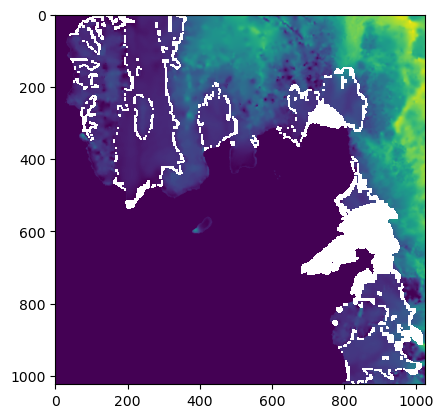

In [260]:
plt.imshow(thickness.loc[1, 2006])

Now we interpolate

In [261]:
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import griddata
from skimage.restoration import inpaint

In [262]:
interpolated_thickness_cnn = pd.DataFrame(index=ids, columns=common_years)

for id in df.index:
    for year in common_years:

        thickness_tmp = thickness.loc[id, year]
        
        mask = np.isnan(thickness_tmp)

        interpolated_thickness_cnn.loc[id,year] = inpaint.inpaint_biharmonic(thickness_tmp, mask)

        #set 0 where there is sea
        interpolated_thickness_cnn.loc[id,year][sea_mask.loc[id, year]] = 0

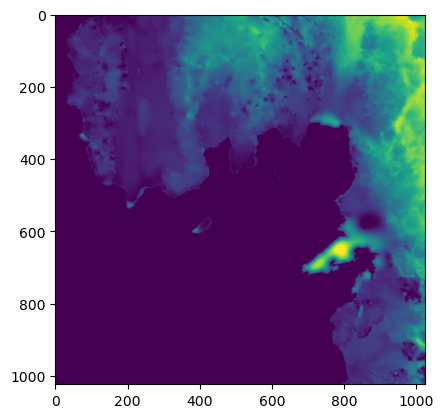

In [263]:
plt.imshow(interpolated_thickness_cnn.loc[1, 2006])

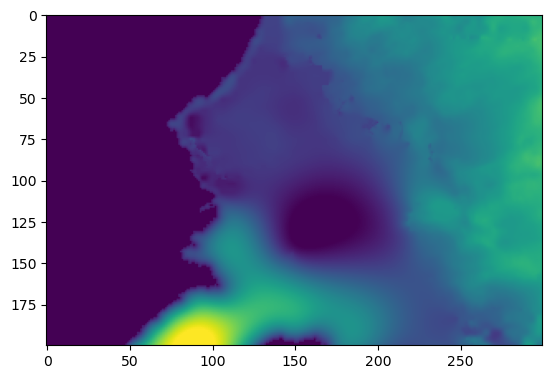

In [264]:
plt.imshow(interpolated_thickness_cnn.loc[1, 2015][450:650,700:1000])

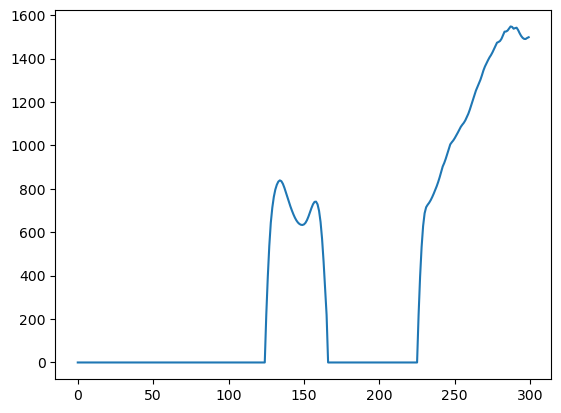

In [240]:
plt.plot(interpolated_thickness_cnn.loc[1, 2015][600,700:1000])

In [265]:
#now i want to try to interpolate differently WE WILL USE THIS METHOD    

import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import griddata

interpolated_thickness_cnn_values_2 = pd.DataFrame(index=ids, columns=common_years)

for id in df.index:
    for year in common_years:

        thickness_tmp = thickness.loc[id, year]

        #get coordinates of nan values
        nan_coords = np.where(np.isnan(thickness_tmp))

        #get not a nan coordinates
        not_nan_coords = np.where(~np.isnan(thickness_tmp))

        #get the values of not nan
        values = thickness_tmp[not_nan_coords]

        #perform interpolation
        interpolated_thickness_cnn_values_2.loc[id,year] = griddata(not_nan_coords, values, nan_coords, method='linear')



In [215]:
np.shape(interpolated_thickness_cnn_values_2.loc[1,2015])

(26568,)

In [266]:
thickness_tif_interpolated_cnn_2 = thickness.copy()

for id in df.index:
    for year in common_years:
        thickness_tif_interpolated_cnn_2.loc[id, year][np.where(np.isnan(thickness_tif_interpolated_cnn_2.loc[id,year]))] = interpolated_thickness_cnn_values_2.loc[id,year]

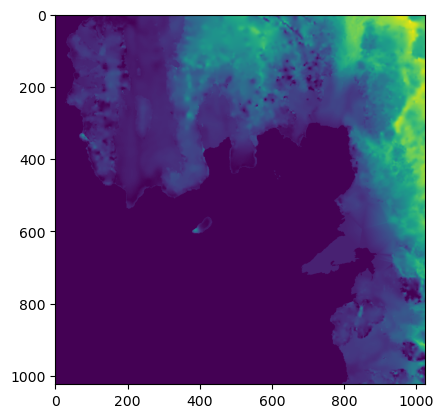

In [267]:
plt.imshow(thickness_tif_interpolated_cnn_2.loc[1, 2006])

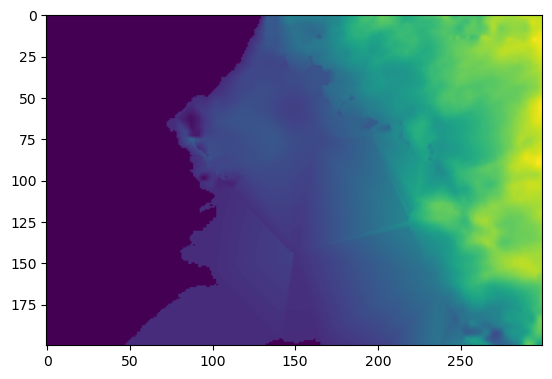

In [268]:
plt.imshow(thickness_tif_interpolated_cnn_2.loc[1, 2015][450:650,700:1000])

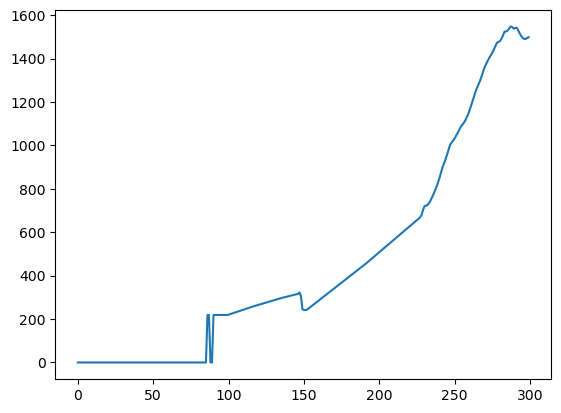

In [269]:
plt.plot(thickness_tif_interpolated_cnn_2.loc[1, 2015][600,700:1000])

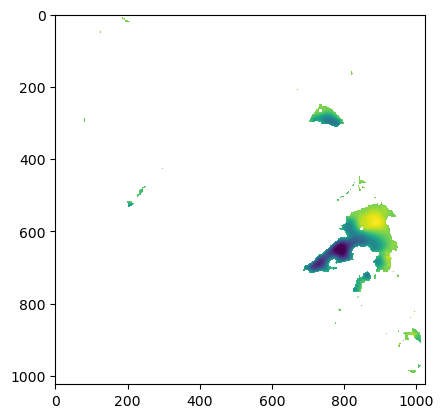

In [270]:
#plot the difference between the two interpolations, and set to nan all the points where is 0


difference_image = thickness_tif_interpolated_cnn_2.loc[1, 2015] - interpolated_thickness_cnn.loc[1, 2015]

# Set all 0 values to nan
difference_image = np.where(difference_image == 0, np.nan, difference_image)

plt.imshow(difference_image)



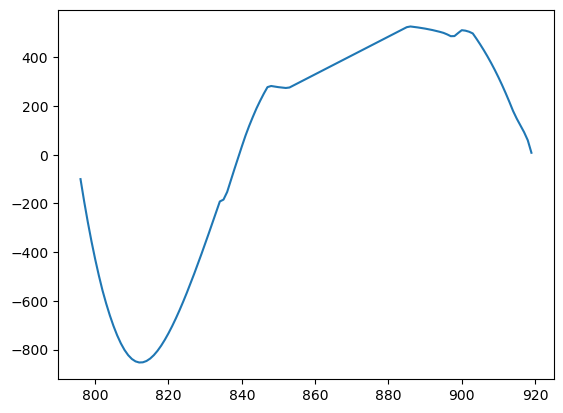

In [271]:
plt.plot(difference_image[580,:])

In [272]:
36*12*15/60

108.0